## Libraries and settings

In [57]:

# Libraries
import os
# os.system('pip install yfinance') to install the yfinance in the current environment
import json
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
import sqlite3

# Settings
import warnings
warnings.filterwarnings("ignore")

# Current working directory
print(f'Current working directory: {os.getcwd()}')

Current working directory: /workspaces/Scientific-Programming_GroupProject


## Download qoutes (stock information) into one file

In [58]:
# List of stocks (quotes)
stocks = ['AAPL', 'MSFT', 'GOOGL', 'META', 'NFLX']

# Empty list to collect data
all_data = []

# Loop through each stock and collect data
for symbol in stocks:
    data = yf.download(symbol, start='2024-11-01', end='2025-04-01')
    data['Symbol'] = symbol  # Add symbol column
    data = data.reset_index()  # Reset index to make Date a column
    all_data.append(data)  # Append to list

# Combine all dataframes
final_df = pd.concat(all_data, ignore_index=True)

# Connect to SQLite
conn = sqlite3.connect('stocks.db')

# Drop existing table to avoid conflicts
conn.execute("DROP TABLE IF EXISTS stock_prices;")

# Save DataFrame to SQLite
final_df.to_sql('stock_prices', conn, if_exists='replace', index=False)

 # Preview the result
print(final_df.head())

# Save the data to a CSV file NEEDED? 
final_df.to_csv('stocks_data.csv', index=False) 

# Connect to SQLite database (creates 'stocks.db' if it doesn't exist)
conn = sqlite3.connect('stocks.db')

# Save a pandas DataFrame to a table in SQLite
final_df.to_sql('stock_prices', conn, if_exists='append', index=False)
# The file 'stocks.db' is where everything is stored (binary format)

# Read the data back from the SQLite database
df = pd.read_sql_query("SELECT * FROM stock_prices LIMIT 10;", conn)
# Close the connection
conn.close() 

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Price        Date       Close        High         Low        Open      Volume  \
Ticker                   AAPL        AAPL        AAPL        AAPL        AAPL   
0      2024-11-01  222.420471  224.855115  219.786270  220.484729  65276700.0   
1      2024-11-04  221.522446  222.300732  219.227509  220.504697  44944500.0   
2      2024-11-05  222.959290  223.458192  220.654365  221.312919  28111300.0   
3      2024-11-06  222.230896  225.573545  220.704257  222.121137  54561100.0   
4      2024-11-07  226.980438  227.379569  224.076840  224.136706  42137700.0   

Price  Symbol Close High  Low  ... Close High  Low Open Volume Close High  \
Ticker         MSFT MSFT MSFT  ...  META META META META   META  NFLX NFLX   
0        AAPL   NaN  NaN  NaN  ...   NaN  NaN  NaN  NaN    NaN   NaN  NaN   
1        AAPL   NaN  NaN  NaN  ...   NaN  NaN  NaN  NaN    NaN   NaN  NaN   
2        AAPL   NaN  NaN  NaN  ...   NaN  NaN  NaN  NaN    NaN   NaN  NaN   
3        AAPL   NaN  NaN  NaN  ...   NaN  NaN  

Strategy A and Strategy B - Comparison

In [59]:
# Read the data from the CSV file
df = pd.read_csv('stocks_data.csv')

def calculate_strategies(df):
    df = df.sort_values(by=['Symbol', 'Date'])  # Ensure chronological order

    # Daily profit: Buy at Open, Sell at Close (same day)
    df['Strategy_A'] = df['Close'] - df['Open']
    
    # Daily profit: Buy at Close, Sell next day's Open
    df['Strategy_B'] = df.groupby('Symbol')['Open'].shift(-1) - df['Close']

    # Cumulative profit over time (assuming 1 share per day)
    df['Cumulative_A'] = df.groupby('Symbol')['Strategy_A'].cumsum()
    df['Cumulative_B'] = df.groupby('Symbol')['Strategy_B'].cumsum()

    return df


cols_to_convert = ['Open', 'Close']
df[cols_to_convert] = df[cols_to_convert].apply(pd.to_numeric, errors='coerce')

# Apply the strategy calculation
processed_df = calculate_strategies(df)

# Preview new columns
print(processed_df[['Date', 'Symbol', 'Open', 'Close', 'Strategy_A', 'Strategy_B', 'Cumulative_A', 'Cumulative_B']].head(20))




          Date Symbol        Open       Close  Strategy_A  Strategy_B  \
1   2024-11-01   AAPL  220.484729  222.420471    1.935742   -1.915775   
2   2024-11-04   AAPL  220.504697  221.522446    1.017749   -0.209527   
3   2024-11-05   AAPL  221.312919  222.959290    1.646370   -0.838153   
4   2024-11-06   AAPL  222.121137  222.230896    0.109759    1.905810   
5   2024-11-07   AAPL  224.136706  226.980438    2.843732   -0.059938   
6   2024-11-08   AAPL  226.920500  226.710739   -0.209761   -1.957846   
7   2024-11-11   AAPL  224.752893  223.983734   -0.769159    0.319656   
8   2024-11-12   AAPL  224.303390  223.983734   -0.319656   -0.219759   
9   2024-11-13   AAPL  223.763975  224.872757    1.108782   -0.099879   
10  2024-11-14   AAPL  224.772878  227.969360    3.196483   -1.818020   
11  2024-11-15   AAPL  226.151340  224.752884   -1.398456    0.249731   
12  2024-11-18   AAPL  225.002615  227.769577    2.766962   -1.038871   
13  2024-11-19   AAPL  226.730706  228.029282    1.

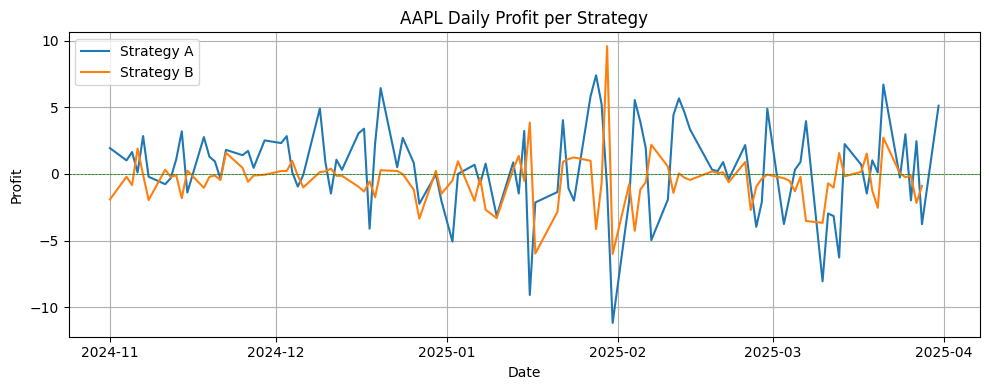

1


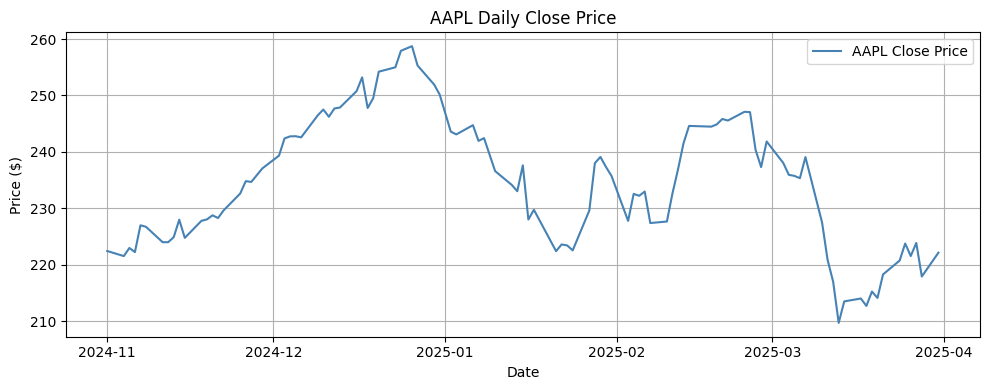

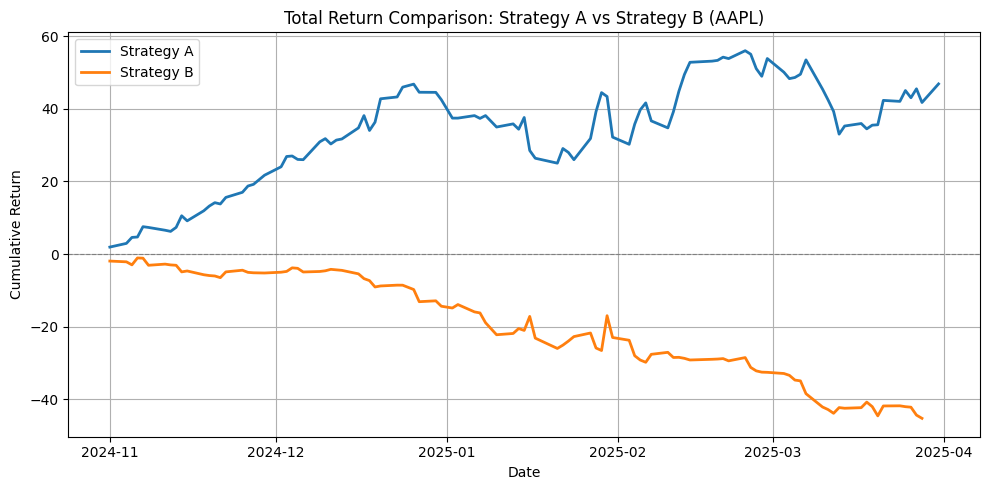

In [72]:
# Filter for AAPL only
stock_data = processed_df[processed_df['Symbol'] == 'AAPL'].copy()

# Make sure 'Date' is in datetime format
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

# Plotting
plt.figure(figsize=(10, 4))
plt.plot(stock_data['Date'], stock_data['Strategy_A'], label='Strategy A')
plt.plot(stock_data['Date'], stock_data['Strategy_B'], label='Strategy B')
plt.title('AAPL Daily Profit per Strategy')
plt.xlabel('Date')
plt.ylabel('Profit')
plt.axhline(0, color='green', linestyle='--', linewidth=0.5)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Get axis before showing the plot
ax = plt.gca()
plt.show()


print(stock_data['Strategy_B'].isna().sum())  # count of missing values



# Filter for AAPL
stock_data = processed_df[processed_df['Symbol'] == 'AAPL'].copy()
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

# Plot daily closing price
plt.figure(figsize=(10, 4))
plt.plot(stock_data['Date'], stock_data['Close'], label='AAPL Close Price', color='steelblue')
plt.title('AAPL Daily Close Price')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Ensure 'Date' is datetime
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

# Calculate cumulative returns
cumulative_a = stock_data['Strategy_A'].cumsum()
cumulative_b = stock_data['Strategy_B'].cumsum()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(stock_data['Date'], cumulative_a, label='Strategy A', linewidth=2)
plt.plot(stock_data['Date'], cumulative_b, label='Strategy B', linewidth=2)
plt.title('Total Return Comparison: Strategy A vs Strategy B (AAPL)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
